In [ ]:
#default_exp peakmaps 

# Distribution maps   

> Dealing with mixed signals 

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2 
%matplotlib notebook

In [ ]:
# hide 
import os 
os.chdir('/home/frank/Work/Projecten/DoRe/viz/raw_nmf')

In [ ]:
#hide 
import numpy as np 
import matplotlib.pyplot as plt 
import skimage.exposure as ske

from maxrf4u import DataStack

In [ ]:
#hide 
ds = DataStack('RP-T-1898-A-3689.datastack') 
extent = ds.read('imvis_extent')
imvis = ds.read('imvis_reg_highres')

x_keVs = ds.read('maxrf_energies') 
y_max = ds.read('maxrf_maxspectrum')
y_sum = ds.read('maxrf_sumspectrum') 

hotmax_pixels = ds.read('hotmax_pixels')
hotmax_spectra = ds.read('hotmax_spectra')
hotmax_baselines = ds.read('hotmax_baselines')

peak_idxs = hotmax_pixels[:,2]

In the previous section we explored spectra and developed an intuition for solving the peak pattern puzzle that each spectrum presents. Every x-ray fluorescence spectrum in our data cube is a sum of spectral patterns due to the presence of a mixture of chemical elements present at the measurement spot. These spectra are further complicated by 1) the presence of a continuum baseline caused by elastic and inelastic scattering of the paper background, and 2) Poisson photon noise. In other words, spectra contain mixed signals. 

In order to arrive at element or material distribution maps, we now need to mathematically unmix the one million spectra from our data cube. Technically speaking we have to factorize our data cube $X$ into components $H$ and weights $W$(concentrations). 

$$ X \approx H \times W $$

Different mathematical techniques have been developed for decomposing spectra into it's components. Best suited to our needs is a technique called Non-negative Matrix Factorization (NMF). Unlike other algorithms the NMF algorithm ensures that both the computed component spectra and their concentrations can not be negative.  

## Nonnegative Matrix Factorization twice 

The NMF algorithm is implemented in the scikit learn package and is fairly straightforward to use. In our case however we need to take into account that our data cube does not fit into memory all at once. As a workaround I will unmix/simplify the spectral data in two steps, applying the NMF algorithm twice.   

**STEP 1: Gaussian peak fitting** 

The idea of step one is resolve the problem of overlapping peak regions using NMF. This is done by first fitting Gaussian shaped peak profiles the all hotmax pixel peaks in all hotmax spectra. In order to get an idea what this means let's first fit the max spectrum using the `fit_spectrum()` function and plot the result. 

In [ ]:
from maxrf4u import fit_spectrum

fitted_list = fit_spectrum(y_max, 'RP-T-1898-A-3689.datastack') 

<IPython.core.display.Javascript object>


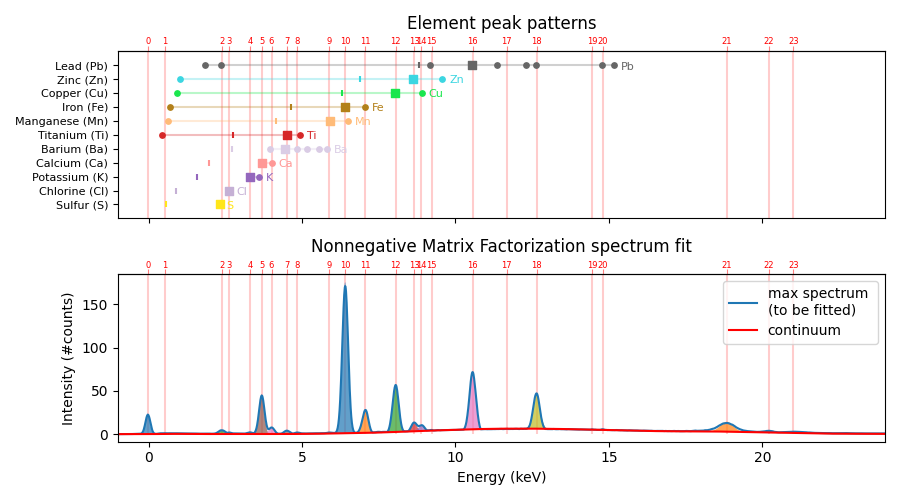

In [ ]:
#collapse-hide 

from maxrf4u import fit_spectrum, get_patterns, plot_patterns
from maxrf4u.peakmaps import _add_hotlines_ticklabels 

fig, [ax, ax1] = plt.subplots(nrows=2, sharex=True, figsize=[9, 5])

# element patterns 

ptrn_list = get_patterns(['S', 'Ca', 'K', 'Cl', 'Fe', 'Mn', 'Cu', 'Zn', 'Pb', 'Ti', 'Ba'])

plot_patterns(ptrn_list, ax=ax)
_add_hotlines_ticklabels('RP-T-1898-A-3689.datastack', ax, clip_vline=False) 
ax.set_title('Element peak patterns')

# NMF fit 

y_cont = fitted_list[-1]

for y_fit in fitted_list[:-1]: 
    ax1.fill_between(x_keVs, y_fit + y_cont, y_cont, where=(y_fit>0.001), alpha=0.7)

ax1.plot(x_keVs, y_max, label='max spectrum \n(to be fitted)') 
ax1.plot(x_keVs, y_cont, color='r', label='continuum')
ax1.set_xlim([-1, 24])
_add_hotlines_ticklabels('RP-T-1898-A-3689.datastack', ax1);


ax1.set_ylabel('Intensity (#counts)')
ax1.set_xlabel('Energy (keV)')
ax1.legend()
ax1.set_title('Nonnegative Matrix Factorization spectrum fit')

plt.tight_layout()

Although some peaks overlap one can see that they are now separated (and filled with different colors) using the NMF algorithm. We can now repeat the same procedure for all spectra in the data cube to produce peak maps. This can be done using the `compute_nmf_peakmaps()` function. On my computer this takes 5m 14s.

In [ ]:
from maxrf4u import compute_nmf_peakmaps, multi_plot 

In [ ]:
peak_maps = compute_nmf_peakmaps('RP-T-1898-A-3689.datastack')

Please wait a few minutes while preparing your peak maps. 
Write peak maps factorization to datastack file [y/n]? y

Saved NMF peak maps data to: RP-T-1898-A-3689.datastack


To get a first idea of the patterns in the peak maps let's histogram equalize the images for maximum contrast and plot the results.  

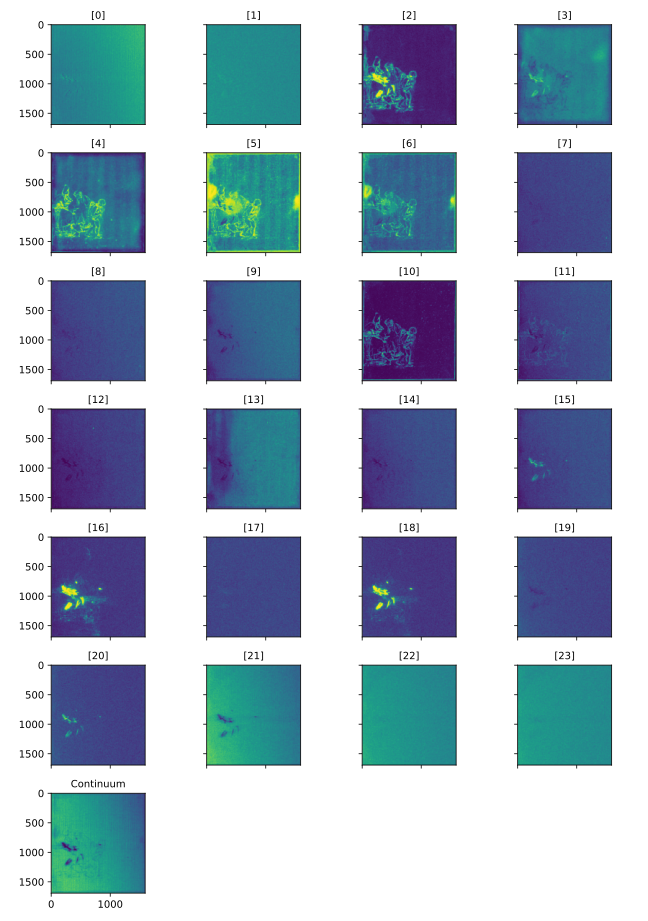

In [ ]:
#collapse-hide 

# no need to compute again 
# we can read our saved peak maps from datastack file 
ds = DataStack('RP-T-1898-A-3689.datastack')
peak_maps = ds.read('nmf_peakmaps')

peak_maps_histeq = [ske.equalize_hist(pm) for pm in peak_maps]

titles = [f'[{i}]' for i in range(len(peak_maps) - 1)]
titles.append('Continuum')

multi_plot(*peak_maps_histeq, titles=titles, svg=True)

## FUNCTIONS

In [ ]:
#export 

from dask import delayed 
from dask.diagnostics import ProgressBar 
import maxrf4u 
import numpy as np 
import scipy.interpolate as sip 
import scipy.signal as ssg 
import matplotlib.pyplot as plt 
from IPython.display import SVG 

import sklearn.decomposition as skd 

#from maxrf4u.peakmaps import _add_hotlines_ticklabels 

def get_continuum(datastack_file): 
    '''Compute continuum baseline from sum spectrum.
    
    Uses rolling ball filter to remove peaks from sum spectrum. 
    
    Returns: y_continuum
    '''
    
    ds = maxrf4u.DataStack(datastack_file) 
    x_keVs = ds.read('maxrf_energies')
    y_sumspectrum = ds.read('maxrf_sumspectrum') 
    
    # rolling ball filter
    y_continuum = maxrf4u.hotmax._baseline(x_keVs, y_sumspectrum) # radius=200 
    # repeat with smaller ball to cut sharp corners of Compton 
    y_continuum =  maxrf4u.hotmax._baseline(x_keVs, y_continuum, radius=40)
    
    return y_continuum 


def _gaussian(x, x0, sigma): 
    '''Normal distribution around `x0` with standard deviation `sigma`.'''
    
    y = np.exp(-0.5 * ((x - x0) / sigma)**2)
    
    return y 


def _fit_gaussian(x, y, peak_idx, rel_height=0.2, baseline=None): 
    '''Fit single gaussian distribution at `rel_height`. 
    
    Returns: `y_gauss`, `baseline`
    '''
    
    # just a single peak 
    [widths], [width_height], [left_ips], [right_ips] = ssg.peak_widths(y, [peak_idx], rel_height=rel_height)
    
    # create energy interpolation 
    keV_ipol = sip.interp1d(np.arange(len(x)), x)
     
    left_x = keV_ipol(left_ips)
    right_x = keV_ipol(right_ips)
    
    # pick smallest half width at rel_height 
    dx_left = left_x - x[peak_idx] 
    dx_right = right_x - x[peak_idx] 
    
    dx = sorted([dx_left, dx_right])[0] 
    
    # create baseline  
    if baseline is None:  
        baseline = np.zeros_like(y) 
        
    y_norm = (width_height - baseline[peak_idx]) / (y[peak_idx] - baseline[peak_idx]) 
    
    # assert that y_norm is positive 
    assert y_norm > 0, f"Can't fit Gaussian for peak below baseline for peak index {peak_idx}."   
        
    # calculate corresponding sigma 
    sigma = np.sqrt(-dx**2 / (2 * np.log(y_norm)))
    
    # calculate gaussian with baseline 
    y_gauss = (y[peak_idx] - baseline[peak_idx]) * _gaussian(x, x[peak_idx], sigma) + baseline
    
    return y_gauss, baseline 


def get_gaussians(datastack_file, tail_clip=0.05): 
    '''Computes fitted and clipped Gaussian peak shapes for all hotmax pixels. 
    
    Returns: y_gauss_list'''
    
    # read stuff from datastack 
    ds = maxrf4u.DataStack(datastack_file) 

    x_keVs = ds.read('maxrf_energies') 
    hotmax_pixels = ds.read('hotmax_pixels')
    hotmax_spectra = ds.read('hotmax_spectra')
    hotmax_baselines = ds.read('hotmax_baselines') 

    peak_idxs = hotmax_pixels[:,2]

    # get slices by fitting gaussian to corresponding hotmax spectrum and baseline 
    y_gauss_list = []

    # Create tail clipped gaussians 
    for i, peak_idx in enumerate(peak_idxs):  

        y_hot = hotmax_spectra[i]
        baseline = hotmax_baselines[i]
        y_gauss_fit, baseline = _fit_gaussian(x_keVs, y_hot, peak_idx, baseline=baseline) 

        y_gauss_flat =  y_gauss_fit - baseline 
        y_gauss_list.append(y_gauss_flat)
        
    return y_gauss_list 


def fit_spectrum(y, datastack_file): 
    '''Fit Gaussian peak shapes to single spectrum `y`.
    
    Uses NMF with fixed Gaussian component vectors. 
    
    Returns: weighed_components_list 
    '''

    X = y.reshape([1, -1]) # make single spectro into two dimenional array 
    

    y_continuum = get_continuum('RP-T-1898-A-3689.datastack')

    y_gauss_list = get_gaussians('RP-T-1898-A-3689.datastack')

    # create component vectors 
    H = np.array([y_gauss for y_gauss in y_gauss_list]).astype(np.float32)
    # add continuum as component
    H = np.r_[H, y_continuum[None,:].astype(np.float32)]
    
    n_components, n_channels = H.shape

    W, H, n_iter = skd.non_negative_factorization(X, H=H, n_components=n_components, update_H=False)

    X_nmf = W @ H 
    y_nmf = X_nmf.flatten()
    
    # now create list of weighed components (peaks) 
    # for easy plotting fitted peaks with individual colors  
    
    W_flat = W.flatten()
    
    fitted_list = []
    
    for i, w in enumerate(W_flat): 
        
        fitted = w * H[i]
        fitted_list.append(fitted) 
        
    return fitted_list  
        

    
def _add_hotlines_ticklabels(datastack_file, ax, clip_vline=True): 
    '''Utility function. Adds hotlines and tick labels to plot `ax`. 
    
    '''
    # read hotlines data 
    ds = maxrf4u.DataStack(datastack_file) 
    x_keVs = ds.read('maxrf_energies')
    peak_idxs = ds.read('hotmax_pixels')[:, 2] 
    
    secax = ax.secondary_xaxis('top')

    secax.set_xticks(x_keVs[peak_idxs]) 
    
    ymin, ymax = ax.get_ylim() 
    
    # clip vlines at y=0
    if clip_vline: 
        ax.vlines(x_keVs[peak_idxs], 0, 1.2*ymax, color='r', alpha=0.2, zorder=9-30)
        ax.set_ylim(ymin, ymax)
    
    # do not clip vlines 
    else: 
        for x in x_keVs[peak_idxs]:
            ax.axvline(x, color='r', alpha=0.2, zorder=9-30)

    secax.set_xticks(x_keVs[peak_idxs])
    secax.set_xticklabels(range(len(peak_idxs)), fontsize=6, color='r') 
    secax.tick_params(color=[1, 0.5, 0.5], pad=0) 
    
    return ax 


def get_spectral_slices(cube): 
    '''Low level bookkeeping to compute slice indices for spectral chunks from dask array `cube`. 
       
    Returns: row_slices, column_slices  
    '''
    
    h, w, d = cube.shape 

    row_chunks, column_chunks, spectral_chunks = cube.chunks

    row_idxs = [0] 
    for c in row_chunks: 
        row_idxs.append(row_idxs[-1] + c)

    row_slices = [[row_idxs[i-1], row_idxs[i]] for i in range(1, len(row_idxs))]

    # columns 
    column_idxs = [0] 
    for c in column_chunks: 
        column_idxs.append(column_idxs[-1] + c)

    column_slices = [[column_idxs[i-1], column_idxs[i]] for i in range(1, len(column_idxs))] 

    return row_slices, column_slices 



def compute_nmf_peakmaps(datastack_file): 
    '''Use nonnegative matrix factorization to compute peak maps spectral data in `datastack_file`. 
    
    Asks to write result to datastack file. 
    
    Returns: peak_maps 
    '''
    
    ds = maxrf4u.DataStack(datastack_file)
    cube = ds.read('maxrf_cube', compute=False)
    h, w, d = cube.shape 
    
    
    # prepare gaussian component vectors 
    y_continuum = get_continuum(datastack_file)
    y_gauss_list = get_gaussians(datastack_file)

    H = np.array([y_gauss for y_gauss in y_gauss_list]).astype(np.float32)
    # add continuum as component
    H = np.r_[H, y_continuum[None,:].astype(np.float32)]

    n_components, n_channels = H.shape

    #initialize peak map stack  
    peak_map_stack = np.zeros([h, w, n_components], dtype=np.float32)

    # prepare chunk bookkeeping 
    row_slices, column_slices = get_spectral_slices(cube)

    n_chunks = len(row_slices) * len(column_slices)

    n = 1 
    print('Please wait a few minutes while preparing your peak maps. ')
    for ri, rj in row_slices: 

        for ci, cj in column_slices: 
            print(f'Computing factorization for spectral chunk {n}/{n_chunks}...', end='\r')

            spectral_chunk = cube[ri:rj, ci:cj, :].compute()
            h, w, d = spectral_chunk.shape
            X = spectral_chunk.reshape([h*w, d])

            W, H, n_iter = skd.non_negative_factorization(X, H=H, n_components=n_components, update_H=False) 

            W_img = W.reshape([h, w, -1]) 

            peak_map_stack[ri:rj, ci:cj] = W_img 
            
            n = n + 1

    peak_maps = peak_map_stack.transpose([2, 0, 1])
    
    # user input           
    write = input('Write peak maps factorization to datastack file [y/n]? ')
         
    if write == 'y': 
        maxrf4u.append(peak_maps, 'nmf_peakmaps', datastack_file)
        maxrf4u.append(H, 'nmf_gausscomponents', datastack_file) 
        
        print(f'\nSaved NMF peak maps data to: {datastack_file}')
    
    return peak_maps 


def multi_plot(*images, hot_pixel=None, titles=None, roi_list=None, axis_off=False,
               sharex=True, sharey=True, vmin=None, vmax=None, cmap='viridis',
               fontsize='medium', zoom_xyc=None, zoom_half_wh=[100, 100], svg=False):
    '''Inspect multiple images simultaneously...
    
    Fold along multiple rows if n > 4'''
    
    if svg:
        plt.ioff()
    
    nrows_max = 4
    n_img = len(images)
    nrows = (n_img // nrows_max) # completely filled rows
    rest = n_img % nrows_max
    if rest != 0:
        nrows = nrows + 1
    if n_img <= nrows_max:
        ncols = n_img
    else:
        ncols = nrows_max
    figsize = [9, 5 + 1.3 * (nrows -1)]
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False, sharex=sharex, sharey=sharey)
    for i, img in enumerate(images):
        axs.flatten()[i].imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
        if hot_pixel is not None:
            hot_yi, hot_xi, hot_zi = hot_pixel
            axs.flatten()[i].scatter(hot_xi, hot_yi, color='r')
        if zoom_xyc is not None:
            xc, yc = zoom_xyc
            w_ha, h_ha = zoom_half_wh
            axs.flatten()[i].set_xlim(xc - w_ha, xc + w_ha)
            axs.flatten()[i].set_ylim(yc + h_ha, yc - h_ha)
        if roi_list is not None:
            add_roi_patches(axs.flatten()[i], roi_list)
    if titles is not None:
        for i, t in enumerate(titles):
            axs.flatten()[i].set_title(t, fontsize=fontsize)
    # seems to have no effect:
    for i in range(n_img, nrows * ncols):
        axs.flatten()[i].axis('off')
    # therefore trying this:
    if axis_off:
        axs_flat = axs.flatten()
        for ax in axs_flat:
            ax.set_axis_off()
    fig.subplots_adjust(hspace=0.1, wspace=0.03)
    plt.tight_layout()
    
    
    # larger image in documentation 
    if svg: 
        plt.savefig('plot.svg')
        fig.clear()
        plt.ion()
        return SVG('plot.svg')
    
    return fig, axs



In [ ]:
elems = ['S', 'Ca', 'K', 'Cl', 'Fe', 'Mn', 'Cu', 'Zn', 'Pb', 'Ti', 'Ba']

In [ ]:
import moseley as mos 

In [ ]:
elem_spectrum = mos.XFluo('S', tube_keV=40)

In [ ]:
import maxrf4u

In [ ]:
from maxrf4u import xrf_spectrum 

In [ ]:
elem_spectrum = xrf_spectrum('Pb', 25, x_keVs=x_keVs)[1]

## Explorations 

### Calcium 

The two calcium maps are really quite similar. 

In [ ]:
black = np.zeros_like(peak_maps[0])
CaKa_map = peak_maps[5]
#CaKa_map = CaKa_map / CaKa_map.max()
CaKb_map = peak_maps[6]
#CaKb_map = CaKb_map / CaKb_map.max()

In [ ]:
CaKa_map.min()

0.0

In [ ]:
img_rgb = np.dstack([black, CaKa_map, CaKb_map])

<IPython.core.display.Javascript object>


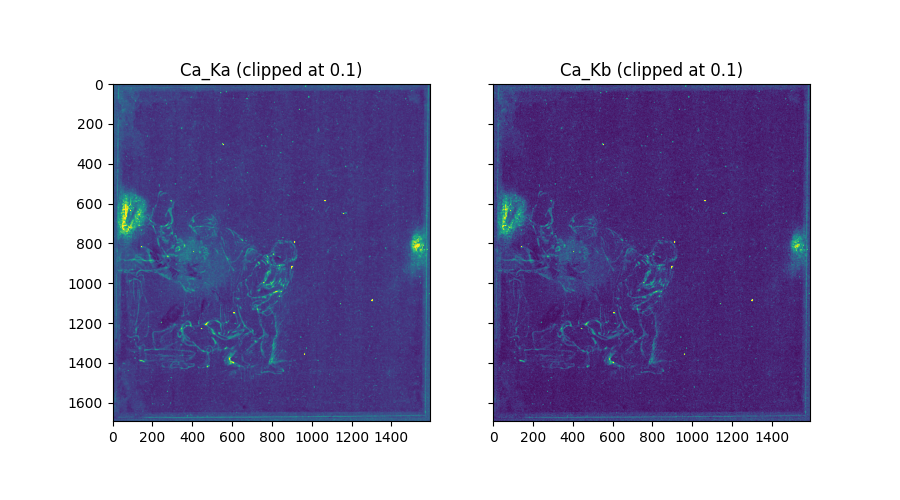

In [ ]:
fig, [ax, ax1] = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=[9, 5])
ax.imshow(CaKa_map, vmax=0.1)
ax1.imshow(CaKb_map, vmax=0.1)
ax.set_title('Ca_Ka (clipped at 0.1)')
ax1.set_title('Ca_Kb (clipped at 0.1)');

### Manganese 

<IPython.core.display.Javascript object>


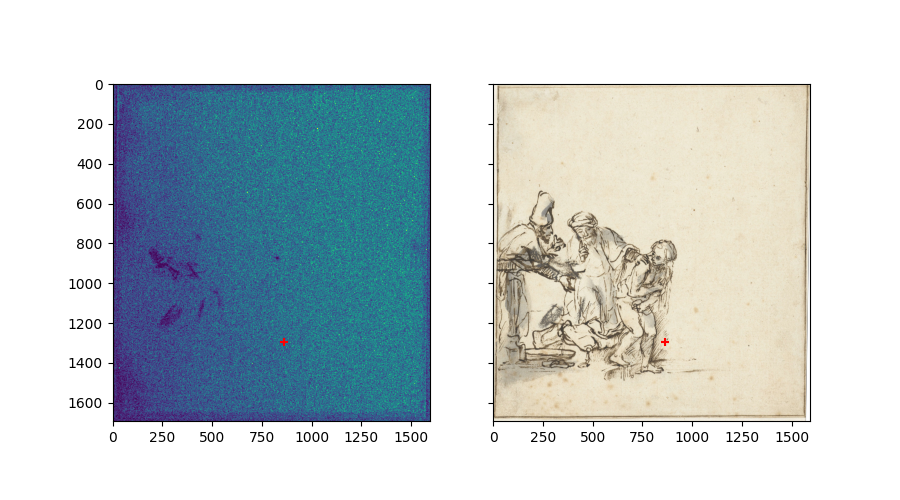

In [ ]:
n = 9
MnKa_map = peak_maps[n]

y, x, z = hotmax_pixels[9]

fig, [ax, ax1] = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=[9, 5])
ax.imshow(MnKa_map, vmax=0.2)
ax.scatter(x, y, color='r', marker='+')
ax1.imshow(imvis, extent=extent)
ax1.scatter(x, y, color='r', marker='+')

I am curious to see how this map compares to the datamunger map... 

<IPython.core.display.Javascript object>


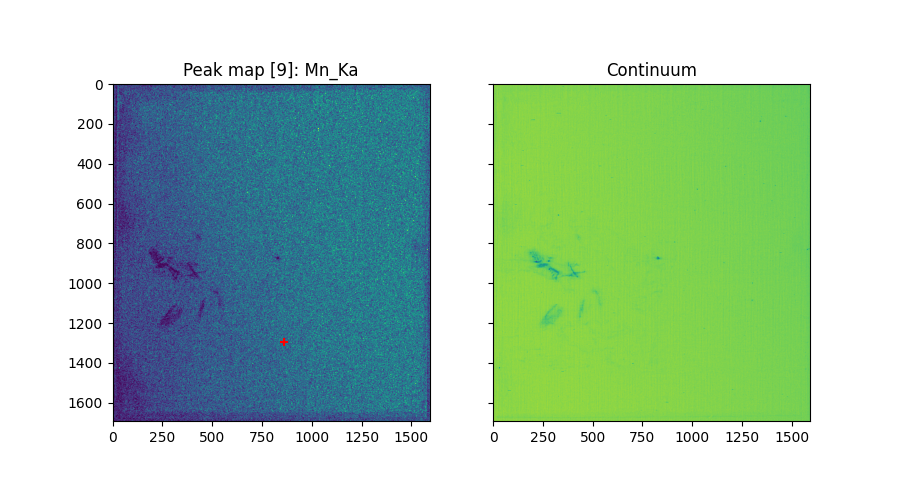

In [ ]:
# no need to compute again 
# we can read our saved peak maps from datastack file 
ds = DataStack('RP-T-1898-A-3689.datastack')
peak_maps = ds.read('nmf_peakmaps')

n = 9
pm = peak_maps[n] 
cont = peak_maps[-1]

y, x, z = hotmax_pixels[n]

fig, [ax, ax1] = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=[9, 5])
ax.imshow(pm, vmax=0.2)
ax1.imshow(cont)

ax.set_title('Peak map [9]: Mn_Ka')
ax.scatter(x, y, color='r', marker='+')
ax1.set_title('Continuum');


It is clear that the lead paint attenuates the manganese signal. One could try to restore this. **Perhaps later.**  

#hide 
# Explorations 

#hide 

## Some notes 

* Peak #5[6]  is an escape peak for Ca_Ka 
* Manganese and chlorine seem like single grains 
* Sulfur is completely hidden by lead 
* Can compute expected Pb peak intensity and subtract 
* Segmentation is a thing 